In [1]:
using MLDatasets
using ImageCore
using LinearAlgebra
using PyPlot
using Random
using Quaternions
using Statistics
using Printf
using JLD2, FileIO
using ProgressMeter
include("HyperRPNNs.jl")
rng = MersenneTwister(1234);

In [2]:
function cifar2gray(x)
    return round.(Int,255*(0.2989*x[:,:,1,1] + 0.5870*x[:,:,2,1]+ 0.1140*x[:,:,3,1]))
end

function gray2bin(x,Nbits=8)
    y = Array{Int64}(undef,length(x),Nbits)
    for i=1:length(x)
        y[i,:] = 2*digits(x[i], base=2, pad = Nbits).-1
    end
    return y, size(x)
end

function bin2gray(y, xsize)
    return reshape([Int(sum(((y[i,:].+1)/2).*2 .^(0:size(y,2)-1))) for i=1:size(y,1)],xsize)
end

function imnoise(img,noise_std = 0.1)
    return clamp.(img + noise_std*randn(rng, Float64, size(img)),0,1)
end

function gray2multistate(x,K)
    zsize = size(x)
    z = exp.(2.0*pi*x*im/K)[:]
    return hcat(real.(z),imag.(z)), zsize
end

function multistate2gray(y,K,ysize)
    z = y[:,1]+y[:,2]*im
    return reshape(Array{Int64}((round.(K*(2*pi.+angle.(z))./(2*pi))).%K),ysize)
end

function gray2multistateC(x,K)
    return exp.(2.0*pi*x*im/K)
end

function multistate2grayC(y,K)
    return Array{Int64}((round.(K*(2*pi.+angle.(y))./(2*pi))).%K)
end

function gray2TwinMultistate(x,K)
    zbin,zsize = gray2bin(x,8)
    c1 = gray2multistateC(bin2gray(zbin[:,1:4],zsize),K)
    c2 = gray2multistateC(bin2gray(zbin[:,5:8],zsize),K)
    return hcat(real.(c1)[:],imag.(c1)[:],real.(c2)[:],imag.(c2)[:]), zsize
end

function TwinMultistate2gray(xc,K,xsize)
    c1, csize = gray2bin(multistate2grayC(xc[:,1]+xc[:,2]*im,K),4)
    c2, csize = gray2bin(multistate2grayC(xc[:,3]+xc[:,4]*im,K),4)
    return bin2gray(hcat(c1,c2),xsize)
end

TwinMultistate2gray (generic function with 1 method)

In [3]:
# load full training set
train_x, train_y = CIFAR10.traindata();

In [4]:
# Select the fundamental memory
P = 200
indFM = randperm(rng, size(train_x)[4])[1:P];

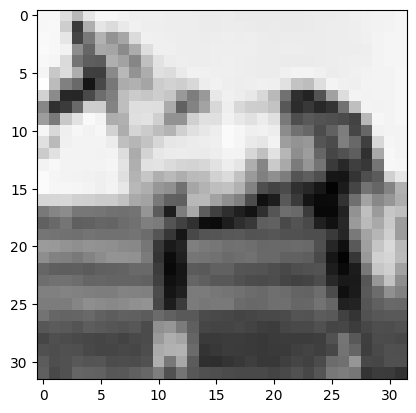

In [5]:
# Select one image from the fundamental memory set
iFMS=200
imgx = cifar2gray(train_x[:,:,:,indFM[iFMS]])
imshow(transpose(imgx),cmap=get_cmap("gray"), vmin=0, vmax=255)
# title("Original (undistorted) image")
savefig("Figures/CIFAR_Original.eps", bbox_inches="tight")
savefig("Figures/CIFAR_Original.pdf", bbox_inches="tight")

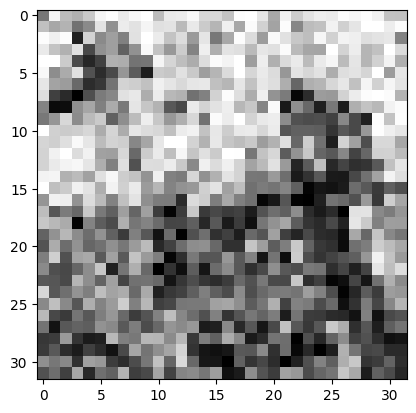

In [6]:
imgxr = cifar2gray(imnoise(train_x[:,:,:,indFM[iFMS]],70/255))
imshow(transpose(imgxr),cmap=get_cmap("gray"), vmin=0, vmax=255)
# title("Corrupted image")
savefig("Figures/CIFAR_Corrupted.eps", bbox_inches="tight")
savefig("Figures/CIFAR_Corrupted.pdf", bbox_inches="tight")

In [7]:
##########################################################################
### Bipolar RPNNs
##########################################################################

  2.466237 seconds (4.02 M allocations: 802.791 MiB, 8.97% gc time)


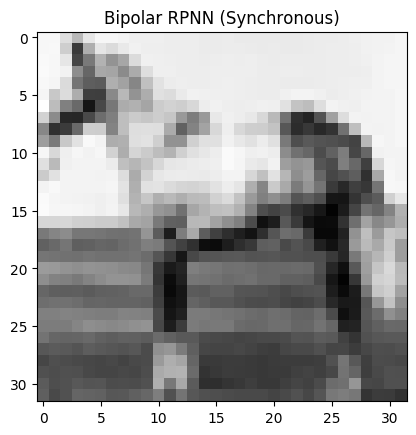

MSE = 0.0

PyObject Text(0.5, 1, 'Bipolar RPNN (Synchronous)')

In [8]:
N = 8*(32*32)
alpha = 20/(8*N)
beta = -20

U = Array{Int64}(undef,N,1,P)
for i=1:P
    ubin, xsize = gray2bin(cifar2gray(train_x[:,:,:,indFM[i]]))
    U[:,1,i] = ubin[:]
end

H = "Real"
BilinearFormParams = [1]
Cinv,U2in = InverseCmatrix.cinversa(H,U,alpha)

##########################################################################
### Synchronous
##########################################################################


x, xsize = gray2bin(imgxr)
@time y, Energy = HyperRPNNs.Sync(HyperRPNNs.LambdaInner,BilinearFormParams,HyperRPNNs.SplitSign,nothing,Cinv,U,reshape(x,8*1024,1),alpha,beta)
imgy = bin2gray(reshape(y,(1024,8)),xsize)
print("MSE = ",sqrt(sum((imgx-imgy).^2)/N))
imshow(transpose(imgy),cmap=get_cmap("gray"), vmin=0, vmax=255)
title("Bipolar RPNN (Synchronous)")

592.676706 seconds (2.21 M allocations: 1.179 TiB, 8.19% gc time)


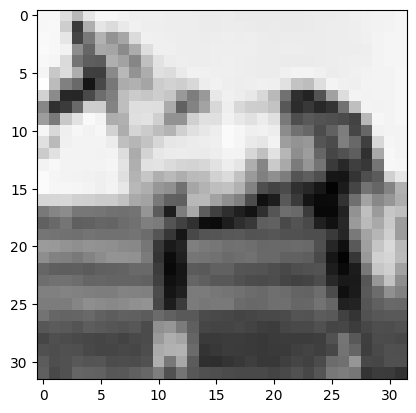

MSE = 0.0

In [9]:
##########################################################################
### Asynchronous
##########################################################################

@time y, Energy = HyperRPNNs.Seq(HyperRPNNs.LambdaInner,[1],HyperRPNNs.SplitSign,nothing,Cinv,U,reshape(x,8*1024,1),alpha,beta)
imgy = bin2gray(reshape(y,(1024,8)),xsize)
print("MSE = ",sqrt(sum((imgx-imgy).^2)/N))
imshow(transpose(imgy),cmap=get_cmap("gray"), vmin=0, vmax=255)
# title("Bipolar ECNN (Asynchronous)")

savefig("Figures/CIFAR_BipolarRPNN.eps", bbox_inches="tight")
savefig("Figures/CIFAR_BipolarRPNN.pdf", bbox_inches="tight")

In [10]:
##########################################################################
### Complex-Valued RPNNs
##########################################################################

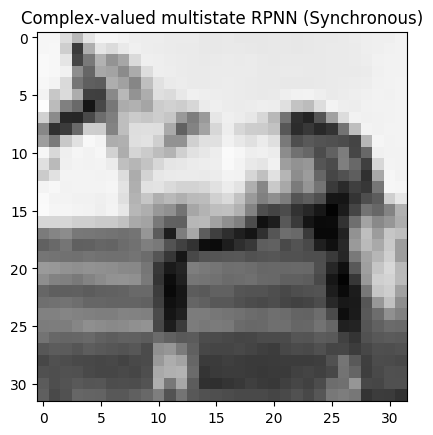

  4.668928 seconds (111.81 M allocations: 2.180 GiB, 7.98% gc time)
MSE = 1.1883220838644715

PyObject Text(0.5, 1, 'Complex-valued multistate RPNN (Synchronous)')

In [11]:
N = 32*32
K = 256
alpha = 20/N
beta = -20

U = Array{Real}(undef,N,2,P)
for i=1:P
    uc, usize = gray2multistate(cifar2gray(train_x[:,:,:,indFM[i]]),K)
    U[:,:,i] = uc
end

H = "Complex"
Cinv,U2in = InverseCmatrix.cinversa(H,U,alpha)


##########################################################################
### Synchronous
##########################################################################

x, xsize = gray2multistate(imgxr,K)
@time y, Energy = HyperRPNNs.Sync(HyperRPNNs.LambdaInner,[1,1],HyperRPNNs.csign,K,Cinv,U,x,alpha,beta)

imgy = multistate2gray(y,K,xsize)
print("MSE = ",sqrt(sum((imgx-imgy).^2)/N))
imshow(transpose(imgy),cmap=get_cmap("gray"), vmin=0, vmax=255)
title("Complex-valued multistate RPNN (Synchronous)")

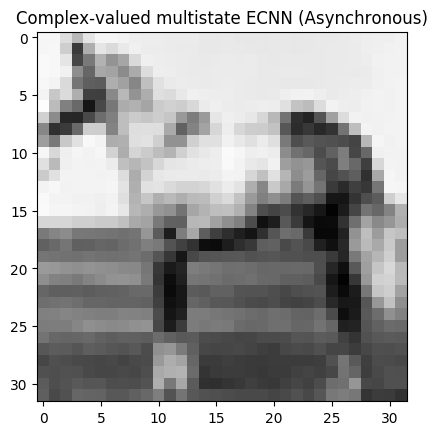

573.093002 seconds (37.06 G allocations: 691.435 GiB, 12.33% gc time)
MSE = 1.2034293446231066

In [12]:
##########################################################################
### Asynchronous
##########################################################################

@time y, Energy = HyperRPNNs.Seq(HyperRPNNs.LambdaInner,[1,1],HyperRPNNs.csign,K,Cinv,U,x,alpha,beta)

imgy = multistate2gray(y,K,xsize)
print("MSE = ",sqrt(sum((imgx-imgy).^2)/N))
imshow(transpose(imgy),cmap=get_cmap("gray"), vmin=0, vmax=255)
title("Complex-valued multistate ECNN (Asynchronous)")

savefig("Figures/CIFAR_CvMultistateRPNN.eps", bbox_inches="tight")
savefig("Figures/CIFAR_CvMultistateRPNN.pdf", bbox_inches="tight")

In [13]:
##########################################################################
### Quaternion-Valued RPNNs
##########################################################################

  2.786060 seconds (92.63 M allocations: 1.743 GiB, 10.92% gc time)
MSE = 

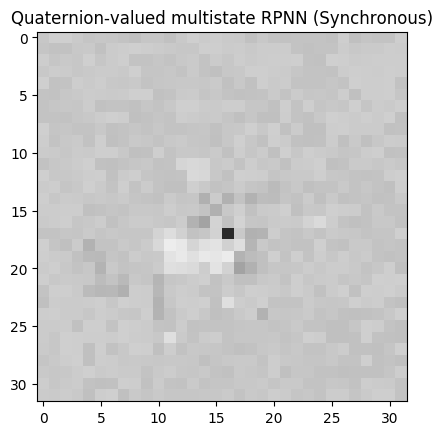

90.29820388579166

PyObject Text(0.5, 1, 'Quaternion-valued multistate RPNN (Synchronous)')

In [14]:
N = 32*32
K = 16
alpha = 20/(2*N)
beta = -20

U = Array{Real}(undef,N,4,P)
for i=1:P
    uc, usize = gray2TwinMultistate(cifar2gray(train_x[:,:,:,indFM[i]]),K)
    U[:,:,i] = uc
end

H = "Quaternions"
Cinv,U2in = InverseCmatrix.cinversa(H,U,alpha)

##########################################################################
### Synchronous
##########################################################################

x, xsize = gray2TwinMultistate(imgxr,K)
@time y, Energy = HyperRPNNs.Sync(HyperRPNNs.LambdaInner,[1,1,1,1],HyperRPNNs.twincsign,16,Cinv,U,x,alpha,beta)
        
imgy = TwinMultistate2gray(y,K,xsize)
print("MSE = ",sqrt(sum((imgx-imgy).^2)/N))
imshow(transpose(imgy),cmap=get_cmap("gray"), vmin=0, vmax=255)
title("Quaternion-valued multistate RPNN (Synchronous)")

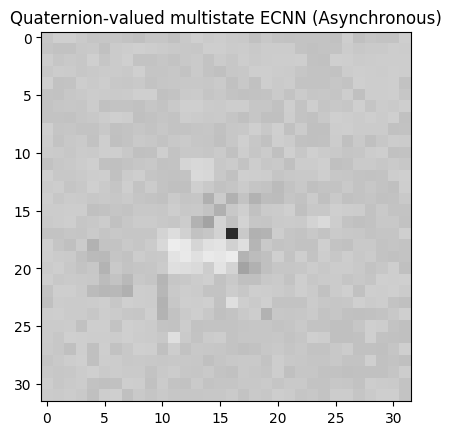

515.323474 seconds (30.32 G allocations: 565.559 GiB, 19.32% gc time)
MSE = 90.2871774620433

In [15]:
##########################################################################
### Asynchronous
##########################################################################

@time y, Energy = HyperRPNNs.Seq(HyperRPNNs.LambdaInner,[1,1,1,1],HyperRPNNs.twincsign,16,Cinv,U,x,alpha,beta)
        
imgy = TwinMultistate2gray(y,K,xsize)
print("MSE = ",sqrt(sum((imgx-imgy).^2)/N))
imshow(transpose(imgy),cmap=get_cmap("gray"), vmin=0, vmax=255)
title("Quaternion-valued multistate ECNN (Asynchronous)")

savefig("Figures/CIFAR_QvMultistateRPNN.eps", bbox_inches="tight")
savefig("Figures/CIFAR_QvMultistateRPNN.pdf", bbox_inches="tight")

In [16]:
##########################################################################
### Octonion Valued RPNNs
##########################################################################

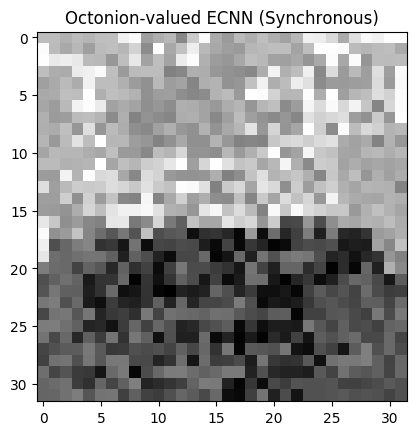

MSE = 63.63239765441815

PyObject Text(0.5, 1, 'Octonion-valued ECNN (Synchronous)')

In [17]:
N = 32*32
alpha = 20/(8*N)
beta = -20

U = Array{Real}(undef,N,8,P)
for i=1:P
    uc, usize = gray2bin(cifar2gray(train_x[:,:,:,indFM[i]]),8)
    U[:,:,i] = uc
end

H = "Octonion"
Cinv,U2in = InverseCmatrix.cinversa(H,U,alpha)

##########################################################################
### Synchronous
##########################################################################

x, xsize = gray2bin(imgxr,8)
y, Energy = HyperRPNNs.Sync(HyperRPNNs.LambdaInner,[1,1,1,1,1,1,1,1],HyperRPNNs.SplitSign,nothing,Cinv,U,x,alpha,beta)

imgy = bin2gray(y,xsize)
print("MSE = ",sqrt(sum((imgx-imgy).^2)/N))
imshow(transpose(imgy),cmap=get_cmap("gray"), vmin=0, vmax=255)
title("Octonion-valued ECNN (Synchronous)")

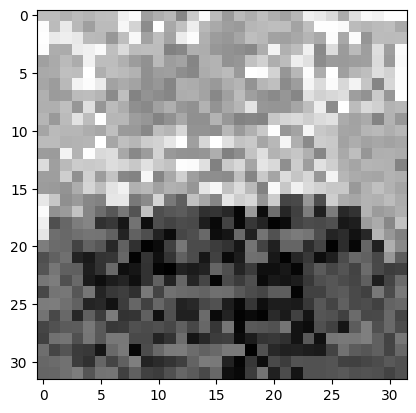

MSE = 63.21232357351294

In [18]:
##########################################################################
### Asynchronous
##########################################################################

y, Energy = HyperRPNNs.Seq(HyperRPNNs.LambdaInner,[1,1,1,1,1,1,1,1],HyperRPNNs.SplitSign,nothing,Cinv,U,x,alpha,beta)

imgy = bin2gray(y,xsize)
print("MSE = ",sqrt(sum((imgx-imgy).^2)/N))
imshow(transpose(imgy),cmap=get_cmap("gray"), vmin=0, vmax=255)
# title("Octonion-valued ECNN (Asynchronous)")

savefig("Figures/CIFAR_OctonionRPNN.eps", bbox_inches="tight")
savefig("Figures/CIFAR_OctonionRPNN.pdf", bbox_inches="tight")

In [19]:
##########################################################################
### Unit Quaternions
##########################################################################

In [20]:
function CIFAR2Quat(x)
    tau = 1.e-4
    phi_ang = (-pi+tau) .+ 2*(pi-tau)*x[:,:,1]
    psi_ang = (-pi/4+tau) .+ (pi/2-2*tau)*x[:,:,2]
    theta_ang = (-pi/2+tau) .+ (pi-2*tau)*x[:,:,3]
    return Quaternion.(cos.(phi_ang),sin.(phi_ang),zeros(32,32),zeros(32,32)).*
        Quaternion.(cos.(psi_ang),zeros(32,32),zeros(32,32),sin.(psi_ang)).*
        Quaternion.(cos.(theta_ang),zeros(32,32),sin.(theta_ang),zeros(32,32));
end

function imnoise(img,noise_std = 0.1)
    return clamp.(img + noise_std*randn(rng, Float64, size(img)),0,1)
end

function Quat2CIFAR(x)
    tau = 1.e-4
    N = size(x,1)
    img_x = zeros(N,3)
    for i=1:length(x)
        q = x[i]/abs(x[i])
        
        # Take the components of q
        a = q.s;
        b = q.v1;
        c = q.v2;
        d = q.v3;
        
        # Rodriguez entries
        R11 = a.^2+b.^2-c.^2-d.^2;
        R13 = 2*(b.*d+a.*c);
        R22 = a.^2-b.^2+c.^2-d.^2;
        R32 = 2*(c.*d+a.*b);
        R12 = 2*(b.*c-a.*d);
        R23 = 2*(c.*d-a.*b);
        R33 = a.^2-b.^2-c.^2+d.^2;
        
        # Psi, Psi, and theta angles
        psiq = real(asin(-R12)/2);
        phiq   = real(atan(R32,R22)/2);
        thetaq = real(atan(R13,R11)/2);
        if abs(abs(psiq)-pi/4)<=tau
            phiq = real(atan(-R23,R33)/2);
            thetaq = 0;
        end
        
        a1   = cos(phiq).*cos(psiq).*cos(thetaq)+sin(phiq).*sin(psiq).*sin(thetaq);
        if (a1*a<0)
            if phiq>=0
                phiq = phiq - pi;
            else
                phiq = phiq + pi;
            end
        end
        R = (phiq+pi-tau)/(2*(pi-tau));
        G = (psiq+pi/4-tau)/((pi/2-2*tau));
        B = (thetaq+pi/2-tau)/((pi-2*tau));
        img_x[i,:] = [R,G,B]
    end
    return img_x
end 

Quat2CIFAR (generic function with 1 method)

In [21]:
function exponential(X,alpha)
    return exp.(alpha*X)
end

exponential (generic function with 1 method)

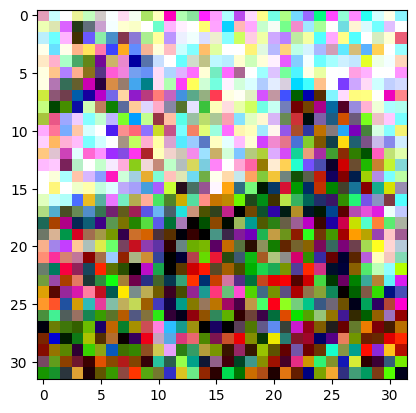

PyObject <matplotlib.image.AxesImage object at 0x7f2474a02160>

In [22]:
N = 32*32
K = 16
alpha = 40
beta = 0

U = Array{Quaternion}(undef,N,P)
for i=1:P
    U[:,i]= CIFAR2Quat(train_x[:,:,:,indFM[i]])[:]
end

Cinv = inv(exponential(Array{Float64}(real(U'*U))/N,alpha));

##########################################################################
### Synchronous
##########################################################################

# Generate a corrupted version of a fundamental memory
NoiseValue = 0.3;

imgx = imnoise(train_x[:,:,:,indFM[iFMS]],NoiseValue)
x = CIFAR2Quat(imgx)[:];
imshow(permutedims(imgx,[2,1,3]))

  6.732535 seconds (131.63 M allocations: 4.641 GiB, 27.20% gc time)
MSE = 

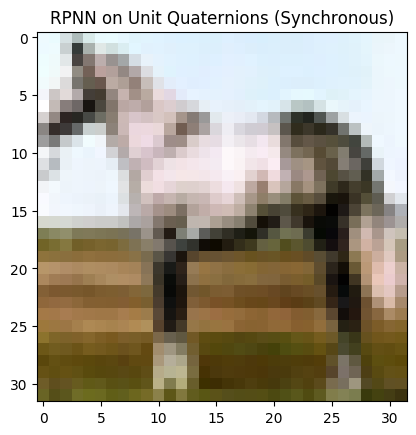

0.4393826338296065

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PyObject Text(0.5, 1, 'RPNN on Unit Quaternions (Synchronous)')

In [23]:
@time y, Energy = HyperRPNNs.UnitQ_Sync(Cinv,U,x,alpha,beta)
imgy = reshape(Quat2CIFAR(y),32,32,3)   
print("MSE = ",sqrt(sum((imgx-imgy).^2)/N))
imshow(permutedims(imgy,[2,1,3]))
title("RPNN on Unit Quaternions (Synchronous)")

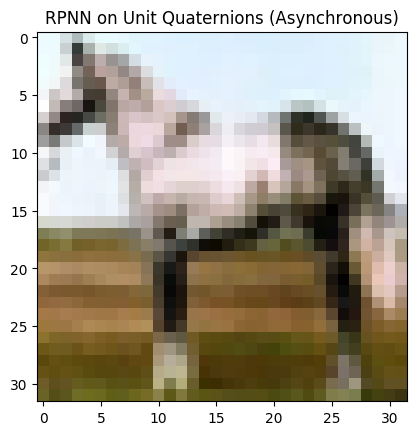

 81.333486 seconds (2.02 G allocations: 88.987 GiB, 40.32% gc time)
MSE = 0.4393826338296064

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PyObject Text(0.5, 1, 'RPNN on Unit Quaternions (Asynchronous)')

In [24]:
##########################################################################
### Asynchronous
##########################################################################
@time y, Energy = HyperRPNNs.UnitQ_Seq(Cinv,U,x,alpha,beta)
        
imgy = reshape(Quat2CIFAR(y),32,32,3)  
print("MSE = ",sqrt(sum((imgx-imgy).^2)/N))
imshow(permutedims(imgy,[2,1,3]))
title("RPNN on Unit Quaternions (Asynchronous)")

In [25]:
savefig("Figures/CIFAR_UnitQ_Sync_RPNN.eps", bbox_inches="tight")
savefig("Figures/CIFAR_UnitQ_Async_RPNN.pdf", bbox_inches="tight")